In [1]:
import requests
from google.cloud import translate
from google.cloud import language_v1
from google.oauth2 import service_account

In [9]:
# Twitter:
bearer = open("./bearer_token.txt").read().strip()

# Google cloud:
PROJECT_ID = open("project_id.txt").read().strip()
parent=f"projects/{PROJECT_ID}/locations/global"
credentials = service_account.Credentials.from_service_account_file('credentials.json')

client = language_v1.LanguageServiceClient(credentials=credentials)
translate_client = translate.TranslationServiceClient(credentials=credentials)

In [10]:
text_type = language_v1.Document.Type.PLAIN_TEXT
language = "en"
encoding_type = language_v1.EncodingType.UTF8

In [45]:
def run_pipeline(language="pl", translate_client=translate_client, sentiment_client=client, parent=parent):
    tweets = get_tweets(lang=language)
    if language == "en":
        return get_sentiments(tweets)
    
    translations = translate_tweets(tweets, language=language)
    sentiments = get_sentiments(translations)
    return sentiments
    
    
def translate_tweets(tweets, language="pl", translate_client=translate_client):
    r_translate = translate_client.translate_text(request = {
        "parent": parent,
        "contents": tweets,
        "source_language_code": language,
        "target_language_code": 'en',
        "mime_type": 'text/plain'
    })
    return [r.translated_text for r in r_translate.translations]
    
    
def get_sentiments(translations, sentiment_client=client):
    sentiments = []
    for text in translations:
        document = {"content": text, "type_": text_type, "language": language}
        response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
        sentiments.append(int(response.document_sentiment.score>0))
    return sentiments



def get_tweets(hashtags=["covid"], keywords=[], lang="pl", bearer=bearer, no_retweets=True, additional="", max_results=10):
    endpoint = f"https://api.twitter.com/2/tweets/search/recent?query="
    
    for h in hashtags:
        endpoint += "%23"+h+" "
        
    for k in keywords:
        endpoint += k+" "
    
    endpoint += "lang:"+lang+" "
    
    if no_retweets:
        endpoint += "-is:retweet "
    
    endpoint += additional+" "
    
    headers = {"Authorization": f"Bearer {bearer}"}
    
    endpoint += f"&max_results={max_results}"
    r = requests.get(endpoint.encode("utf-8"), headers=headers).json()
    return [data["text"] for data in r['data']]

# Demo

In [12]:
r = get_tweets()

In [13]:
r

['@rzeczpospolita @tterlikowski #COVID-19 szczepienia poza kolejnością. Drodzy #celebryci, nie frasujcie się, dupka do góry! Już wkrótce może sam #Prezes #PiS #Kaczyński ogłosi amnestię, udzieli dyspensy, bo nie sposób powstrzymać od szczepień wielkiej armii #TerazKurwaMy!',
 'W kolejce na test na #COVID  jeszcze kilka aut przede mną. https://t.co/TIkCxfh6gF',
 'Dezinformacja jest ich mieczem.\nA Informacja, nasza tarcza.\n#covid #cowid #znakowaniebydla #rfidchip #czip #kryptowaluta #cryptocurrencyNWO #RESET #NewWorldOrder #nowarzeczywistosc #nowanormalnosc',
 '@rzeczpospolita #COVID-19 szczepienia poza kolejnością. Drodzy #celebryci, nie frasujcie się, dupka do góry! Już wkrótce może sam #Prezes #PiS #Kaczyński ogłosi amnestię, udzieli dyspensy, bo nie sposób powstrzymać od szczepień wielkiej armii #TerazKurwaMy!',
 'Informacja Prezesa Urzędu z dnia 09.01.2021 r. o publikacji w językach narodowych UE decyzji Komisji Europejskiej dotyczącej dopuszczenia do obrotu na terytorium UE szcze

In [14]:
t = translate_tweets(r, language="pl")

In [15]:
t

["@rzeczpospolita @tterlikowski # COVID-19 vaccinations out of sequence. Dear #celebrities, don't worry, asshole up! Soon, #PiS #PiS # Kaczyński himself may announce an amnesty, grant dispensation, because it is impossible to stop the great army #TerazKurwaMy from vaccinating!",
 'There are still a few cars ahead of me for the #COVID test. https://t.co/TIkCxfh6gF',
 'Disinformation is their sword.\nA Information, our shield.\n#covid #cowid #znakowaniebydla #rfidchip #czip #cryptocurrency #cryptocurrencyNWO #RESET #NewWorldOrder #nowarzeczyreal #nowanormalnosc',
 "@rzeczpospolita # COVID-19 vaccinations out of sequence. Dear #celebrities, don't worry, asshole up! Soon, #PiS #PiS # Kaczyński himself may announce an amnesty, grant dispensation, because it is impossible to stop the great army #TerazKurwaMy from vaccinating!",
 'Information of the President of the Office of January 9, 2021 on the publication in the EU national languages of the decision of the European Commission regarding t

In [16]:
s = get_sentiments(t)

In [17]:
s

[1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [18]:
def get_name(n):
    if n==1:
        return "Positive"
    return "Negative"

In [19]:
summary = [f"Original tweet: {tweet}\n Translated tweet: {translation}\n Sentiment: {get_name(sentiment)}" for tweet, translation, sentiment in zip(r, t, s)]

In [20]:
for s in summary[:4]:
    print(s)
    print()

Original tweet: @rzeczpospolita @tterlikowski #COVID-19 szczepienia poza kolejnością. Drodzy #celebryci, nie frasujcie się, dupka do góry! Już wkrótce może sam #Prezes #PiS #Kaczyński ogłosi amnestię, udzieli dyspensy, bo nie sposób powstrzymać od szczepień wielkiej armii #TerazKurwaMy!
 Translated tweet: @rzeczpospolita @tterlikowski # COVID-19 vaccinations out of sequence. Dear #celebrities, don't worry, asshole up! Soon, #PiS #PiS # Kaczyński himself may announce an amnesty, grant dispensation, because it is impossible to stop the great army #TerazKurwaMy from vaccinating!
 Sentiment: Positive

Original tweet: W kolejce na test na #COVID  jeszcze kilka aut przede mną. https://t.co/TIkCxfh6gF
 Translated tweet: There are still a few cars ahead of me for the #COVID test. https://t.co/TIkCxfh6gF
 Sentiment: Positive

Original tweet: Dezinformacja jest ich mieczem.
A Informacja, nasza tarcza.
#covid #cowid #znakowaniebydla #rfidchip #czip #kryptowaluta #cryptocurrencyNWO #RESET #NewWorl

# Whole pipeline:

### Sentiments in Poland:

In [21]:
run_pipeline()

[1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

### Sentiments in Spain:

In [22]:
run_pipeline('es')

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1]

## Languages
English (default) en  
Arabic  ar  
Bengali bn  
Czech cs  
Danish  da  
German  de  
Greek el  
Spanish es  
Persian fa  
Finnish fi  
Filipino  fil  
French  fr  
Hebrew  he  
Hindi hi  
Hungarian hu  
Indonesian  id  
Italian it  
Japanese  ja  
Korean  ko  
Malay msa  
Dutch nl  
Norwegian no  
Polish  pl  
Portuguese  pt  
Romanian  ro  
Russian ru  
Swedish sv  
Thai  th  
Turkish tr  
Ukrainian uk  
Urdu  ur  
Vietnamese  vi  
Chinese (Simplified)  zh-cn  
Chinese (Traditional) zh-tw  

In [23]:
import time
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

In [46]:
def plot_sentiments(results):
    formatted_data = []
    columns=["country", "percentPos", "percentNeg"]
    
    for language, data in results.items():
        percPos = data[1]*100/data[0]
        formatted_data.append((language, percPos, 100-percPos))
        
    df = pd.DataFrame(formatted_data, columns=columns)
    
    df.plot( 
      x = 'country',  
      kind = 'barh',  
      stacked = True,  
      title = 'Sentiment for tweets with hashtag COVID per country',
      mark_right = True,
     figsize=(14,8))
    plt.legend(["Percent of positive tweets", "Percent of negative tweets"])
    
    

In [47]:
def analyze_twitter(languages, streaming=False):
    results = {}
    
    while True:
        clear_output(wait=True)
        for language in languages:
            sentiments = run_pipeline(language=language)
            if language not in results:
                results[language] = [0, 0]

            results[language][0] += len(sentiments)
            results[language][1] += sum(sentiments)
            
        plot_sentiments(results)
        if not streaming:
            return
        plt.show()
        time.sleep(10)

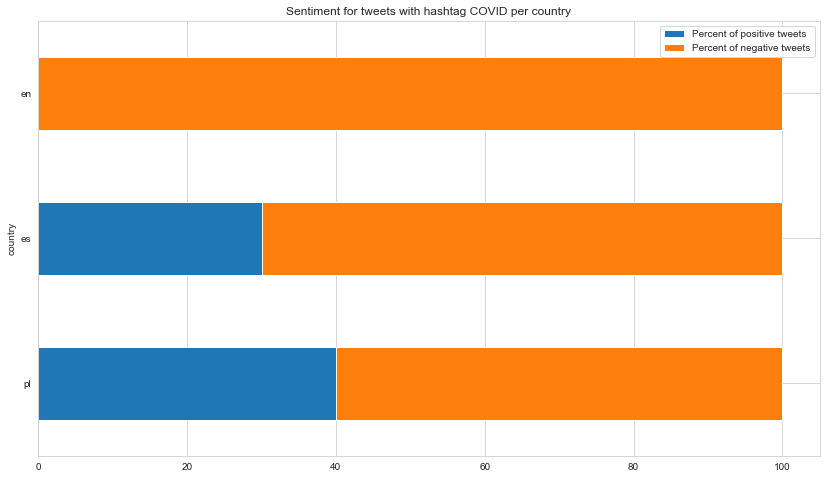

In [48]:
analyze_twitter(['pl', 'es', 'en'])

In [ ]:
analyze_twitter(['pl', 'es'], streaming=True)
